This is Part 2 of a series of notebooks showing how to plot GINI-formatted satellite data from a THREDDS server using [MetPy](http://metpy.readthedocs.org) and [Siphon](http://siphon.readthedocs.org). In [Part 1](Plotting_GINI_Water_Vapor_Imagery_Part1.ipynb) we covered how to access and parse the data file. In this part, we cover:

- Grabbing the data from the file
- Making sense of the projection information
- Plotting with [CartoPy](http://scitools.org.uk/cartopy/) and [matplotlib](http://matplotlib.org)

If you'd like to follow along at home, this post is available as a Jupyter [notebook](https://github.com/unidata/blog-notebooks). The [README](https://github.com/unidata/blog-notebooks) file there has instructions on how to set up a Python environment and run the notebooks we'll be creating for these and future posts.

This first cell contains all of the code from needed to get started; for more information, see [Part 1](Plotting_GINI_Water_Vapor_Imagery_Part1.ipynb).

In [1]:
# Imports
from urllib.request import urlopen

from metpy.io.gini import GiniFile
from siphon.catalog import TDSCatalog

# Grab the catalog and then the dataset for the most recent file
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/satellite/WV/EAST-CONUS_4km/current/catalog.xml')
dataset_name = sorted(cat.datasets.keys())[-1]
dataset = cat.datasets[dataset_name]

# Open the GINI file using MetPy and grab as a NetCDF-like Dataset object
remote_gini_file = urlopen(dataset.access_urls['HTTPServer'])
gini = GiniFile(remote_gini_file)
gini_ds = gini.to_dataset()

## Grabbing data from the file
Our goal is to plot water vapor imagery, so we're going to ask for `WV` from the `.variables` dictionary.
Rather than just giving back the raw array of data, this gives back a `Variable` object; from here not only
can we get the raw data values, but there is useful metadata as well. We can see just what additional information
is present by printing out the `Variable` object:

In [2]:
data_var = gini_ds.variables['WV']
print(data_var)

<class 'metpy.io.cdm.Variable'>: uint8 WV(y, x)
	long_name: WV (6.5/6.7 micron)
	missing_value: 255
	coordinates: y x
	grid_mapping: Lambert_Conformal
	shape = (1280, 1280)


This reveals several useful pieces of information (such as a longer description of the variable), but we're going to focus on two particular attributes: `coordinates` and `grid_mapping`. These two attributes are defined by the [NetCDF Climate and Forecast (CF) Metadata Conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html). The `coordinates` attribute specifies what other variables are needed to reference the variable in time and space; the `grid_mapping` attribute specifies a variable that contains information about the grid's projection.

This tells us that we need to grab the data from the `x` and `y` variable objects for plotting. We use an empty slice (`[:]`) to copy the actual numeric values out of the variables (for easier use with matplotlib and cartopy).

In [3]:
x = gini_ds.variables['x'][:]
y = gini_ds.variables['y'][:]

We also then grab the variable corresponding to the `grid_mapping` attribute so that we can have a look at the projection information. Rather than hard coding the name of the variable (in this case `Lambert_Conformal`), we just directly pass the `grid_mapping` attribute to the `.variables` dictionary; this makes it easier to re-use the code in the future with different data.

In [4]:
proj_var = gini_ds.variables[data_var.grid_mapping]

## Setting up the projection
To make sense of the data, we need to see what kind of projection we're working with. The first step is to print out the projection variable and see what it says:

In [5]:
print(proj_var)

<class 'metpy.io.cdm.Variable'>: int32 Lambert_Conformal()
	grid_mapping_name: lambert_conformal_conic
	standard_parallel: 25.0
	longitude_of_central_meridian: -95.0
	latitude_of_projection_origin: 25.0
	earth_radius: 6371200.0


This shows that the projection is Lambert conformal; the variable also includes a few parameters (such as the latitude and longitude of the origin) needed to properly set up the projection to match what was used to create the image. This variable also has information about the assumed shape of the earth, which in this case is spherical with a radius of 6371.2 km.

The first step to use this information for plotting is to import Cartopy's `crs` (Coordinate Reference System) module; from this module we create a `Globe` object that allows us to encode the assumed shape and size of the earth:

In [6]:
import cartopy.crs as ccrs

# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.earth_radius,
                   semiminor_axis=proj_var.earth_radius)

From here, we use the `LambertConformal` class to create a Lambert conformal projection with all of the attributes that were specified in the file. We also include the `Globe` object we created.

In [7]:
proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

## Plotting with CartoPy

Now that we know how to properly reference the imagery data (using the `LambertConformal` projection object), we can plot
the data. CartoPy's projections are designed to interface with matplotlib, so they can just be passed as the `projection` keyword argument when creating an `Axes` using the `add_subplot` method. Since the x and y coordinates, as well as the image data, are referenced in the lambert conformal projection, so we can pass all of them in directly to plotting methods (such as `imshow`) with no additional information. The `extent` keyword argument to `imshow` is used to specify the bounds of the image data being plotted.

/Users/rmay/miniconda3/envs/metpy3/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


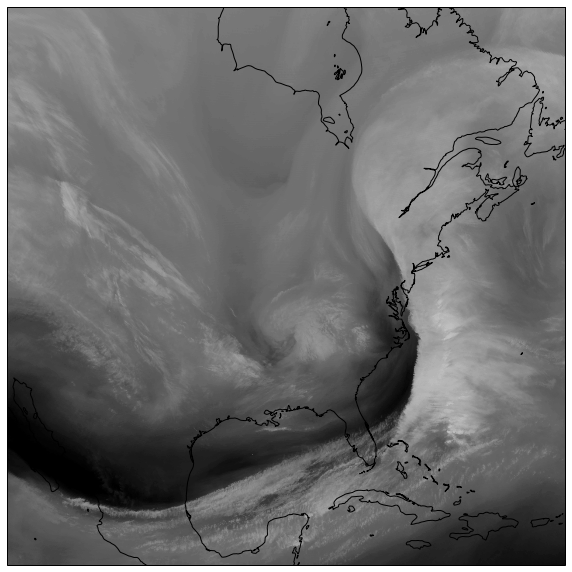

In [8]:
# Make sure the notebook puts figures inline
%matplotlib inline
import matplotlib.pyplot as plt

# Create a new figure with size 10" by 10"
fig = plt.figure(figsize=(10, 10))

# Put a single axes on this figure; set the projection for the axes to be our
# Lambert conformal projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the data using a simple greyscale colormap (with black for low values);
# set the colormap to extend over a range of values from 140 to 255.
# Note, we save the image returned by imshow for later...
im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap='Greys_r', norm=plt.Normalize(140, 255))

# Add high-resolution coastlines to the plot
ax.coastlines(resolution='50m', color='black')

This is a nice start, but it would be nice to have better geographic references for the image. Fortunately, Cartopy's `feature` module has support for adding geographic features to plots. Many features are built in; for instance, the `BORDERS` built-in feature contains country borders. There is also support for creating "custom" features from the [Natural Earth](http://www.naturalearthdata.com/) set of free vector and raster map data; CartoPy will automatically download the necessary data and cache it locally. Here we create a feature for states/provinces.

/Users/rmay/miniconda3/envs/metpy3/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


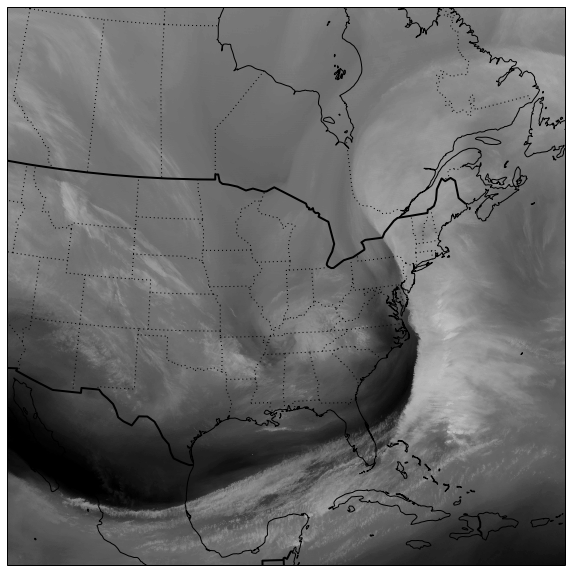

In [9]:
import cartopy.feature as cfeat

# Add country borders with a thick line.
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='50m', facecolor='none')

# Add the feature with dotted lines, denoted by ':'
ax.add_feature(state_boundaries, linestyle=':')

# Redisplay modified figure
fig

The map is much improved now; but it would look so much better in color! Let's play with the colormapping of the imagery a little...

Colormapping in matplotlib (which backs CartoPy) is handled through two pieces:

- The colormap controls how values are converted from floating point values in the range [0, 1] to colors (think colortable)
- The norm (normalization) controls how data values are converted to floating point values in the range [0, 1]

We import the `ColortableRegistry` from Metpy's `metpy.plots.ctables` module. This registry provides access to the wide array of colormaps available in MetPy. It also provides convenience methods to grab a colormap (`wv_cmap`) along with a `Normalization` instance (`wv_norm`) appropriate to the number of colors in the colortable. The code below asks for the `WVCIMSS` colormap (converted from GEMPAK), along with a normalization that starts at 0 and increases by a value of 1 for each color in the table.

In [10]:
from metpy.plots.ctables import registry
wv_norm, wv_cmap = registry.get_with_steps('WVCIMSS', 0, 1)

Now we can use the `im` object we saved earlier and reset the cmap and norm on the image to the new ones:

/Users/rmay/miniconda3/envs/metpy3/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


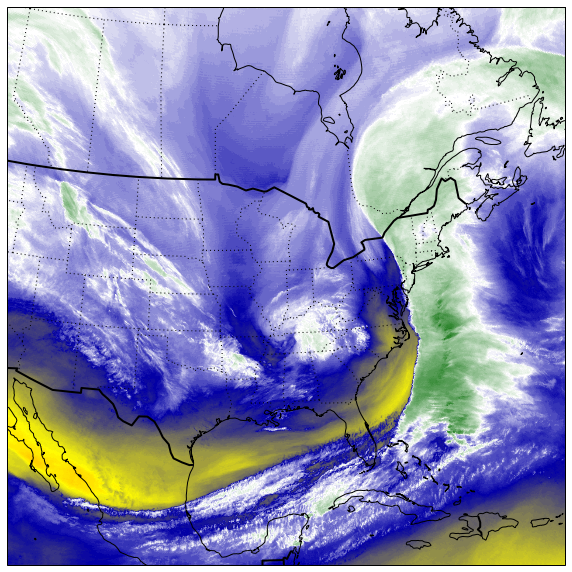

In [11]:
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)
fig

One more thing that would be nice is putting the date and time on the image, so let's do that. First grab the `time` variable from the file:

In [12]:
time_var = gini_ds.variables['time']
print(time_var)

<class 'metpy.io.cdm.Variable'>: int32 time(time)
	units: milliseconds since 2016-02-16T00:00:00
	shape = 1


So we have a variable with a single time, expressed as a count of milliseconds since a reference time. We could parse this manually easily enough, but the netcdf4-python package has this already covered with its `num2date` function, so why rewrite it? We just need to import it and pass it the values (throwing them into `squeeze()` to remove all the extra dimensions) and units:

In [13]:
from netCDF4 import num2date
timestamp = num2date(time_var[:].squeeze(), time_var.units)
timestamp

datetime.datetime(2016, 2, 16, 20, 15, 20)

Great! A sensible time object to work with. Let's add it to our plot.

We use the `text` method to draw text on our plot. In this case, we call it with a `transform` keyword argument, which allows us to tell matplotlib how to interpret the x and y coordinates. In this case, we set the transfrom to `ax.transAxes`, which means "interpret x and y as being in axes space"; axes space has x and y in the range [0, 1] across the entire plotting area (e.g. (0, 0) is lower left, (1, 1) is upper right). Using this, we can put text in the lower right corner (`x = 0.99`, `y = 0.01`) regardless of the range of x and y (or longitude and latitude) in the plot. We also need to make sure to right-align the text so that the text *ends* at the specified point.

We use the `strftime` method to format the datetime as a string. The details of that format string are described [here](https://docs.python.org/3.5/library/datetime.html#strftime-strptime-behavior).

The code below uses matplotlib's [path effects](http://matplotlib.org/users/patheffects_guide.html) to make the text have an outline effect as well. We won't go into detail on that here, so see the linked
[documentation](http://matplotlib.org/users/patheffects_guide.html) for more information.

For completeness, the code below replicates the entirety of the plotting code from above.

/Users/rmay/miniconda3/envs/metpy3/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


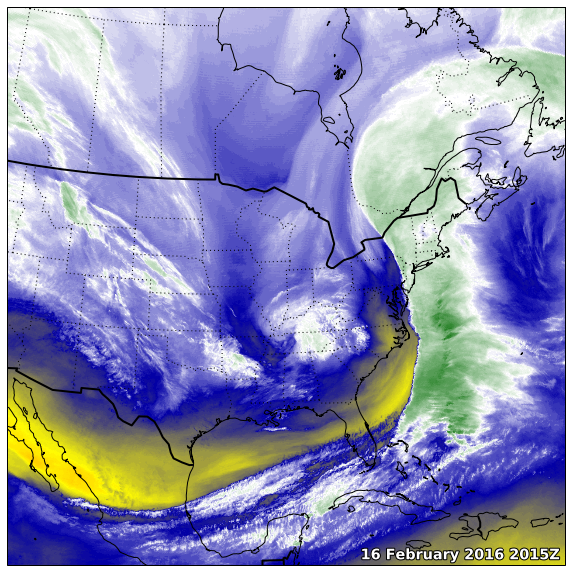

In [14]:
# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(data_var[:], extent=(x[0], x[-1], y[0], y[-1]), origin='upper',
               cmap=wv_cmap, norm=wv_norm)
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
from matplotlib import patheffects
text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'),
                       patheffects.Normal()])

## Conclusion
That completes our example of plotting water vapor imagery. We managed to:

- Download data from Unidata's [demonstration THREDDS server](http://thredds.ucar.edu/thredds/) using [Siphon](http://siphon.readthedocs.org)
- Read the GINI data using [MetPy](http://metpy.readthedocs.org)
- Plot the data on a map using [CartoPy](http://scitools.org.uk/cartopy/) (and [matplotlib](http://matplotlib.org))

This example really only scratches the surface of what's possible. If you'd like to explore more, start by exploring the documentation for the various projects; there you'll find a variety of examples showcasing even more features.

### Additional resources
- [MetPy Documentation](http://metpy.readthedocs.org)
- [Siphon Documentation](http://siphon.readthedocs.org)
- [Unidata Blog Notebooks](http://github.com/Unidata/blog-notebooks) ([View Here](http://nbviewer.jupyter.org/github/unidata/blog-notebooks/tree/master/notebooks/))
- [Notebooks](http://github.com/Unidata/unidata-python-workshop) from Unidata's Annual Python Training Workshop

Was this too much detail? Too slow? Just right? Do you have suggestions on other topics or examples we should cover? Do you have a notebook you would like us to show off? We'd love to have your feedback. You can send a message to the (python-users AT unidata.ucar.edu) [mailing list](https://www.unidata.ucar.edu/support/#mailinglists) or send a message to support-python AT unidata.ucar.edu. You can also leave a comment below, directly on the blog post.